# ML 기말고사 정리

## 1. Decision tree

### 1.1 entropy

높을수록 불안정한 값. 낮춰야하는 값.

$$
entropy = H(S) = -\sum_c^C{p(c) \times \log_2 p(c)}
$$

In [1]:
from math import log2

def entropy(*events):
    total = sum(events) + 1e-5
    result = 0
    for el in events:
        if el == 0: continue # 앞의 p(c)가 0이라서 어차피 0이므로 그냥 통과~
        prob = el / total
        result -= prob * log2(prob)
    return result

In [2]:
entropy(5, 9)

0.9402863175336368

노드의 구성에 따라서 엔트로피가 어떻게 바뀌는지를 그래프로 그려보면 다음 그래프처럼 나온다.

(0.5, 0.5) 구성일 때 가장 높고, (0, 1) 또는 (1, 0)일 때 가장 낮게 나온다.

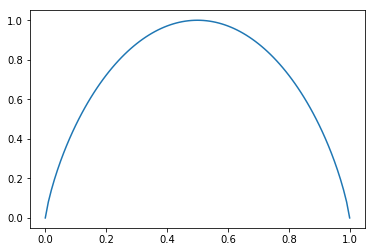

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x1 = np.arange(0, 1.001, 0.01)
x2 = 1 - x1

y = [entropy(x1[i], x2[i]) for i in range(len(x1))]
plt.plot(x1, y)
plt.show()

### 1.2 Information gain

$$
IG = H(S) - \sum_{i \in {L,R}}{|S^i| \over |S|}H(S^i)
$$

- 어떤 한 attribute으로 데이터를 쪼갰을 때, 쪼개지 않았을 때에 비해 entropy가 얼마나 떨어지느냐
- IG는 parent node 엔트로피에서 child node 엔트로피의 weighted sum을 뺀 값
    + weighted의 의미는 각각의 나눠지는 child node들이 parent node에서 어느정도의 비율로 examples를 가져가는지
    + $|S|$ 는 전체 examples의 개수, $|S_i|$는 i label의 examples 개수를 말하고 이 비율이 weight다.
    + 위 공식에서 L, R은 그냥 이 케이스를 binary로 본것이고 Left, Right를 의미
- 각 attribute로 parent node를 쪼개서 IG를 모두 구해보고, 가장 높은 IG를 갖는 attribute 선택

In [4]:
def information_gain(parent, *children):
    p_en = entropy(*parent)
    c_en = []
    for child in children:
        c_en.append(sum(child)/sum(parent) * entropy(*child))
    return p_en - sum(c_en)

In [5]:
information_gain([10, 20], [3, 14], [7, 6])

0.10584664415241218

### 1.3 Examples

![Imgur](https://i.imgur.com/W3NmiSe.png)

아래 식을 계산해보면 Outlook이 가장 높은 IG를 가지므로 Root node를 처음 나누는 기준은 Outlook이 된다.

In [6]:
outlook_IG = information_gain([9, 5], [2, 3], [4, 0], [3, 2])
temperature_IG = information_gain([9, 5], [2, 2], [4, 2], [3, 1])
humidity_IG = information_gain([9, 5], [3, 4], [6, 1])
wind_IG = information_gain([9, 5], [3, 3], [6, 2])

print("IG\n==========")
print("Outlook: {}".format(outlook_IG))
print("Temperature: {}".format(temperature_IG))
print("Humidity: {}".format(humidity_IG))
print("Wind: {}".format(wind_IG))

IG
Outlook: 0.24674847422762258
Temperature: 0.029221782734249135
Humidity: 0.15183492559303535
Wind: 0.048126622051042234


## 2. MLE, MAP

### 2.1 개념

- MLE : 각 사건의 확률에 발생 횟수를 제곱해서 모두 곱한 값. 주로 log를 취해서 summation 형태로 푼다. 결국 likelihood가 최대가 되는 확률은 단순히 "해당 사건 발생 횟수 / 전체 사건 발생 횟수"로 계산하면 됨
- MAP : 위 계산한 MLE에 prior 확률 값을 곱해주기만 하면 끝. 수식적으로 각각의 확률의 승수 부분에 prior를 더해줘서 풀어도 상관 없음

### 2.2 Casino coin 예제

$$
\left\{ 
\begin{array}{ll}
Data = {H, T, H, H, H, T, T} \\
\text{fair_coin}: P(H)=0.5, P(T)=0.5, P(fair)=0.99 \\
\text{loaded_coin}: P(H)=0.6, P(T)=0.4, P(loaded)=0.01
\end{array}
\right.
$$

---

**MLE: 카지노가 loaded coin을 썼다고 판단** (0.0078 < 0.0083)

$$
\left\{ 
\begin{array}{ll}
MLE_{fair} = (0.5)^4 \times (0.5)^3 = 0.0078125 \\
MLE_{loaded} = (0.6)^4 \times (0.4)^3 = 0.0082944
\end{array}
\right.
$$

**MAP: 카지노가 fair coin을 썼다고 판단** (0.0077 > 0.0001)

$$
\left\{ 
\begin{array}{ll}
MLE_{fair} = (0.5)^4 \times (0.5)^3 \times 0.99 = 0.007734375 \\
MLE_{loaded} = (0.6)^4 \times (0.4)^3 \times 0.01 = 0.000082944
\end{array}
\right.
$$

## 3. Naive Bayes

### 3.1 개념

$$
P(Y|X) = {P(X|Y)P(Y) \over P(X)}
$$

- 일단 우리가 구하려고 하는것은 `P(Y|X)`다. X라는 데이터가 주어졌을 때 이게 어떤 Y를 나타내는건지를 알고싶은 것
- 근데 이건 X의 진짜 분포를 알 수 없으므로 구할 수 없기 때문에 Bayes theorem으로 식을 변형해서 구해본다.
- Bayes theorem으로 식을 변형해서 우항처럼 구해야할 값이 바뀌었다.
    + `P(X|Y)`만을 maximize하는 Y를 구한다면 MLE로 문제를 푸는 것이고,
    + `P(X|Y)*P(Y)` 전체를 maximize한다면 MAP 형태로 문제를 푸는 것이다.

---

$$
\left\{ 
\begin{array}{ll}
P(X|Y) = P(x_1, x_2, x_3 | Y) \\ 
P(X|Y)= p(x_1|Y)\times p(x_2|Y)\times p(x_3|Y)
\end{array}
\right.
$$

- Feature가 3개인 데이터가 N개 존재한다고 가정해보자. 그러면 `P(X|Y)`는 위처럼 3개 feature에 대한 joint probability 형태로 표현할 수 있다.
- 기존 베이즈 방식으로 joint probability를 계산
    + x1, x2, x3가 일반적으로 분명히 연관이 있을것이므로
    + 여러 조건부 확률의 곱으로 decompose 해야한다.
    + 계산이 복잡하고 연산량도 많아짐
- 모든 Feature가 독립이라고 naive하게 가정하고 푸는 것이 Naive Bayes 방식. 위 수식처럼 각 확률을 곱해버린다
- 모든 Y값에 대해 각각 Naive Bayes로 확률을 구해보고, 그 중 가장 높은 Y를 선택하면 된다.

### 3.2 테니스 예제

![Imgur](https://i.imgur.com/W3NmiSe.png)

Question : 만약 X = {Outlook=Sunny, Temperature=Cool, Humidity=High, Wind=Strong} 이라면 테니스를 칠 것인가?

---

**테니스를 칠 확률은**

$$
\left\{ 
\begin{array}{ll}
P(Y=Yes | X) \\
= {P(X|Y=Yes)P(Y) \over P(X)} \\
= P(Sunny|Yes)P(Cool|Yes)P(High|Yes)P(Strong|Yes)P(Yes) \over P(X) \\
= 2/9 \times 3/9 \times 3/9 \times 3/9 \times 9/14 \over P(X) \\
= 0.005291
\end{array}
\right.
$$

**테니스를 치지 않을 확률은**

$$
\left\{ 
\begin{array}{ll}
P(Y=No | X) \\
= {P(X|Y=No)P(Y) \over P(X)} \\
= P(Sunny|No)P(Cool|No)P(High|No)P(Strong|No)P(No) \over P(X) \\
= 3/5 \times 1/5 \times 4/5 \times 3/5 \times 5/14 \over P(X) \\
= 0.020571
\end{array}
\right.
$$

`P(Y=No|X)`가 0.02로 `P(Y=Yes|X)`의 0.005보다 더 높기 때문에 테니스를 치지 않을 것으로 결론.